## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
from PIL import Image
from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping

%matplotlib inline

## Data Augmentation

Use the ImageDataGenerator class from the Keras library to create a function that generate augmented images.

In [2]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    # iterate over the files in the specified directory
    for filename in listdir(file_dir):
        # load the image (reads the image as a NumPy array.)
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image to include an additional dimension. 
        #This is done to match the expected input shape of the flow method of ImageDataGenerator, 
        #which expects a 4D tensor with dimensions (batch_size, height, width, channels).
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

Call the function to generate augmented data for both "no" and "yes" examples

In [3]:
yes_path = 'yes'
no_path = 'no'
augmented_data_path = 'augmented data/'

# augment data for the examples with label equal to 'yes' representing tumurous examples (n generated samples-6)
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+ 'yes')
# augment data for the examples with label equal to 'no* representing non-tumurous examples (n generated samples-6)
augment_data(file_dir=no_path, n_generated_samples=6, save_to_dir=augmented_data_path+'no')

Get the number of positive and negative examples.

In [4]:
yes_path = 'augmented data/yes'
no_path = 'augmented data/no'
# number of files (images) that are in the the folder named 'ves that represent tumorous (positive) examples
m_pos = len(listdir(yes_path))
# number of files (images) that are in the the folder named "no° that represent non-tumorous (negative) examples
m_neg = len(listdir(no_path))
# number of all examples
m = m_pos + m_neg
print(f"Number of examples: {m}")
print(f"Number of pos examples: {m_pos}")
print(f"Number of neg examples: {m_neg}")

Number of examples: 4625
Number of pos examples: 3253
Number of neg examples: 1372


## Image Denoising

In [5]:
image = cv2.imread('yes/Y1.jpg')

Convert the image to grayscale, and blur it slightly

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise.

In [7]:
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]: This line applies a binary thresholding operation to the grayscale image. The cv2.threshold function is used, which takes four arguments:
- The source image (gray) to be thresholded.
- The threshold value (45 in this case). Pixel intensities below this threshold will be set to 0, and intensities above or equal to the threshold will be set to the maximum value (255 in this case).
- The maximum value to be assigned to pixels that pass the threshold test (255 in this case).
- The thresholding type (cv2.THRESH_BINARY). This type specifies that a binary thresholding operation should be applied, where pixel values below the threshold are set to 0, and values above or equal to the threshold are set to the maximum value.
- The result of the thresholding operation is returned as a tuple, and we select the second element ([1]) of the tuple, which corresponds to the thresholded image. The thresholded image is stored in the variable thresh.

thresh = cv2.erode(thresh, None, iterations=2): This line performs an erosion operation on the thresholded image. The cv2.erode function is used, which takes three arguments:
- The source image (thresh) to be eroded.
- The kernel used for erosion (None in this case). When set to None, a default 3x3 rectangular kernel is used.
- The number of iterations to apply the erosion operation (2 in this case). This determines how many times the erosion operation is applied to the image.
- The erosion operation erodes away the boundaries of foreground objects in the image, effectively reducing their size and removing small details or noise.

thresh = cv2.dilate(thresh, None, iterations=2): This line performs a dilation operation on the eroded image. The cv2.dilate function is used, which takes the same three arguments as the cv2.erode function.
- The source image (thresh) to be dilated.
- The kernel used for dilation (None in this case), which defaults to a 3x3 rectangular kernel.
- The number of iterations to apply the dilation operation (2 in this case).
- The dilation operation expands the boundaries of foreground objects in the image, making them larger and filling in gaps or holes that may exist.

These operations are commonly used to separate objects from the background or to extract specific regions of interest based on their intensity values.

Find contours in thresholded image, then grab the largest one

In [8]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

Find the extreme points

In [9]:
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

Crop new image out of the original image using the four extreme points (left, right, top, bottom)

In [10]:
new_img = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]  

Plot the original image and the image after the denoising process

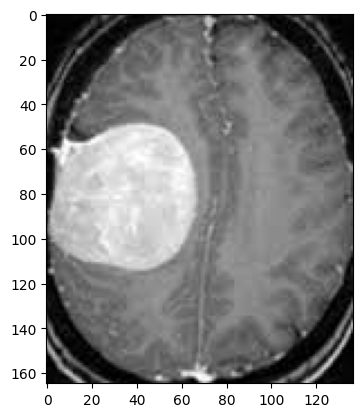

In [12]:
from matplotlib import pyplot as plt
plt.imshow(new_img)


Create a function that do the whole denoising process

In [13]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)


    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    gray = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    gray = cv2.erode(gray, None, iterations=2)
    gray = cv2.dilate(gray, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])

    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]             

    return new_image

## Data normalization

Resize the image (width = 240, height = 240)

In [14]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
image = cv2.imread('yes/Y1.jpg')

Normalize image

In [15]:
image = image / 255.

- image: The variable image contains the image data, which is typically represented as a multi-dimensional array.

- / 255: This division operation divides each element in the image array by the value 255.

Normalization: By dividing each pixel value by 255, the pixel values are scaled down to the range of 0 to 1. This process is known as normalization, where the pixel intensities are rescaled to a standard range to facilitate further processing or analysis.

Create a function that do the whole preprocessing steps to the data and return X: processed images as arrays and y: their corresponding labels.

In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            # Construct the full file path
            img_path = os.path.join(directory, filename)
            
            # Load the image
            image = load_img(img_path, target_size=(image_width, image_height))
            
            # Crop and resize the image if needed
            image = crop_brain_contour(image)
            image = resize_img(image, image_width, image_height)
            
            # Convert the image to a NumPy array and normalize it
            image = img_to_array(image) / 255.0
            
            # Append image data and label
            X.append(image)
            
            # Determine label based on directory name
            if 'yes' in os.path.basename(directory):
                y.append(1)
            else:
                y.append(0)
    
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y, random_state=42)
    
    return X, y

# Example of usage:
# augmented_path = 'augmented data/'
# augmented_yes = os.path.join(augmented_path, 'yes')
# augmented_no = os.path.join(augmented_path, 'no')
# IMG_WIDTH, IMG_HEIGHT = 240, 240
# X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
def crop_brain_contour(image):
    # Your implementation for cropping the brain contour
    # Convert to NumPy array if needed
    return image

def resize_img(image, width, height):
    # Your implementation for resizing the image
    return image



Call the function to load our data

In [31]:
augmented_path = 'augmented data/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no' 

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], [IMG_WIDTH, IMG_HEIGHT])


Create a function that splits the dataset into training, validation, and testing sets using the train_test_split function. 

In [32]:
def split_data(X, y, test_size):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Call that function to split the data. the proportion of the dataset to be allocated for testing and validation is 30%.

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, 0.15)

# Build and train models for Brain Tumor Detection using SKLEARN pipelines 

Flatten the input images to a 1D array

In [35]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Flattening the images is commonly performed when using traditional machine learning algorithms, which do not inherently handle multi-dimensional data. It simplifies the data representation and ensures that the algorithm can interpret the input correctly.

## Naive Bayes Classifier

Create an instance of the NB classifier

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
NB = MultinomialNB()

Train the SVM model on the training data

In [37]:
NB.fit(X_train_flat, y_train)

MultinomialNB()

Make predictions on the test set

In [38]:
NB_pred = NB.predict(X_test_flat)

Evaluate the model on the test set (create the classification report)

In [39]:
print(classification_report(y_test, NB_pred,target_names=["No Brain Tumor Detected", "Brain Tumor Detected"]))
print('accuracy score %s' % accuracy_score(y_test, NB_pred))

                         precision    recall  f1-score   support

No Brain Tumor Detected       0.46      0.72      0.56       107
   Brain Tumor Detected       0.83      0.62      0.71       240

               accuracy                           0.65       347
              macro avg       0.64      0.67      0.63       347
           weighted avg       0.72      0.65      0.66       347

accuracy score 0.6484149855907781


 ## Support Vector Machine

Same process using SVM

In [41]:
from sklearn.svm import SVC
from sklearn.utils import shuffle

# Example: Flattening the image data
def flatten_images(X):
    # Assuming X is of shape (num_samples, height, width, channels)
    num_samples, height, width, channels = X.shape
    return X.reshape(num_samples, height * width * channels)

# Flatten the training and test images
X_train_flattened = flatten_images(X_train)
X_test_flattened = flatten_images(X_test)

# Create an instance of the classifier
instance = SVC()

# Train the model on the training data
train = instance.fit(X_train_flattened, y_train)

# Make predictions on the test set
pred = train.predict(X_test_flattened)

# Evaluate the model on the test set
eval = train.score(X_test_flattened, y_test)

print(f"Accuracy: {eval}")


Accuracy: 0.8155619596541787


## Logistic Regression

Same process using LR

In [42]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the classifier
SVM = LogisticRegression()

# Train the model on the training data
SVM.fit(X_train_flat, y_train)

# Make predictions on the test set
pred = SVM.predict(X_test_flat)

# Evaluate the model on the test set
eval = SVM.score(X_test_flat, y_test)

c:\Users\omidk\notebook\neuroscan\NeuroScan\tf_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Save the best model using pickle

In [44]:
if not os.path.exists('models'):
    os.makedirs('models')
directory = 'models'
if not os.path.exists(directory):
    os.makedirs(directory)
filename = 'models/svm_classifier.sav'
pickle.dump(SVM, open(filename, 'wb'))

Import the model

In [45]:
filename = 'models/svm_classifier.sav'
loaded_model = pickle.load(open(filename, 'rb'))

Create a function that takes the path of an image and returns if it contains brain tumor or not using the loaded model

In [46]:
def predict(image_path):
    image = cv2.imread(image_path)
    image = crop_brain_contour(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.
    image_flat = image.reshape(1, -1)

    prediction = loaded_model.predict(image_flat)

    if prediction[0] == 1:
        return "Brain Tumor Detected"
    else:
        return "No Brain Tumor Detected"

Use the predict function

In [48]:
predict('yes/Y2.jpg')


'Brain Tumor Detected'

# Build and train models for Brain Tumor Detection using Neural Networks (CNN) 

Create a function to build the model

In [49]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) 
    
    # Apply zero-padding to the input tensor
    X = ZeroPadding2D((2, 2))(X_input) 
    
    # Apply a convolutional layer followed by batch normalization and ReLU activation
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    # Apply max pooling to reduce spatial dimensions
    X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    # Flatten the tensor to prepare for the fully connected layers
    X = Flatten()(X) 
    # Apply a fully connected layer with a sigmoid activation to obtain the final output
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    # Create the model instance using the input and output tensors
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape and build the model

In [50]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)

Show the model summary

In [51]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The compile function configures the model for training by specifying the optimizer, loss function, and evaluation metrics to be used.

- optimizer='adam' sets the Adam optimizer as the optimization algorithm. Adam is a popular optimizer that adjusts the learning rate dynamically during training to improve convergence.
- loss='binary_crossentropy' sets the binary cross-entropy loss function. This loss function is commonly used for binary classification tasks, such as distinguishing between brain tumor and non-tumor images.
- metrics=['accuracy'] specifies that the accuracy metric should be used to evaluate the model's performance during training and evaluation.

By calling model.compile with these arguments, you configure the model to use Adam optimizer, binary cross-entropy loss, and track the accuracy metric during training and evaluation. 

Define the early stopping criteria

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Train the model

In [54]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 578ms/step - accuracy: 0.7277 - loss: 0.6232 - val_accuracy: 0.7810 - val_loss: 0.5152
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 584ms/step - accuracy: 0.8118 - loss: 0.4371 - val_accuracy: 0.7954 - val_loss: 0.4687
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 584ms/step - accuracy: 0.8448 - loss: 0.3682 - val_accuracy: 0.8012 - val_loss: 0.4696
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 71s 577ms/step - accuracy: 0.8396 - loss: 0.3886 - val_accuracy: 0.8357 - val_loss: 0.4119
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 70s 566ms/step - accuracy: 0.8667 - loss: 0.3237 - val_accuracy: 0.7954 - val_loss: 0.4377
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 69s 561ms/step - accuracy: 0.8703 - loss: 0.3125 - val_accuracy: 0.8415 - val_loss: 0.4710
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 69s 558ms/step - accuracy: 0.8548 - loss: 0.3383 - val_accuracy: 0.7262 - val_loss: 0.5998
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 69s 558ms/step - accuracy: 0.8869 - loss: 0

Save the model

In [55]:
model.save('models/cnn_model.h5')

Load the model

In [56]:
loaded_model = load_model('models/cnn_model.h5')

Evaluate the model

In [57]:
loss, accuracy = loaded_model.evaluate(x=X_test, y=y_test)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8528 - loss: 0.3670
Test Loss = 0.35621199011802673
Test Accuracy = 0.8645533323287964


Create a function that takes the path of an image and returns if it contains brain tumor or not using the loaded model

In [58]:
def predict(path):
    image = cv2.imread(path)
    X = []
    image_width, image_height = (240, 240)
    # crop the brain and ignore the unnecessary rest part of the image
    image = crop_brain_contour(image)
    # resize image
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    image = image / 255.
    # convert image to numpy array and append it to X
    X.append(image)
    X = np.array(X)   
    predicting = loaded_model.predict(X)[0][0]
    if predicting >= 0.5:
        return "Brain Tumor Detected"
    else:
        return "No Brain Tumor Detected"

Use the predict function

In [59]:
predict('yes/Y2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


'Brain Tumor Detected'